In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

import os

from env import get_connection
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
url = get_connection("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
food_types_df = df[["Fresh", 'Grocery', 'Frozen']]
food_types_df.head()

,Fresh,Grocery,Frozen
customer_id,,,
0,12669,7561,214
1,7057,9568,1762
2,6353,7684,2405
3,13265,4221,6404
4,22615,7198,3915


In [4]:
# Make the scaler
mms = MinMaxScaler()

#Fit/transform the scaler
food_types_df = mms.fit_transform(food_types_df)

food_types_df

array([[0.11294004, 0.08146416, 0.0031063 ],
       [0.06289903, 0.10309667, 0.02854842],
       [0.05662161, 0.08278992, 0.03911643],
       ...,
       [0.1295431 , 0.32594285, 0.00677142],
       [0.091727  , 0.02402535, 0.01664914],
       [0.02482434, 0.02702178, 0.00065742]])

In [5]:

# Now, let's add the scaled value columns back onto the dataframe
columns = ["Fresh", "Grocery", "Frozen" ]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(food_types_df, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [6]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen
0,2,3,12669,9656,7561,214,2674,1338,0.112940,0.081464,0.003106
1,2,3,7057,9810,9568,1762,3293,1776,0.062899,0.103097,0.028548
2,2,3,6353,8808,7684,2405,3516,7844,0.056622,0.082790,0.039116
3,1,3,13265,1196,4221,6404,507,1788,0.118254,0.045464,0.104842
4,2,3,22615,5410,7198,3915,1777,5185,0.201626,0.077552,0.063934


In [7]:
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(food_types_df)

DBSCAN(eps=0.1, min_samples=20)

In [8]:
df['food_labels'] = dbsc.labels_
df.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen,food_labels
240,1,1,22096,3575,7041,11422,343,2564,0.196999,0.075859,0.187315,0
72,1,3,4420,5139,2661,8872,1321,181,0.039385,0.028649,0.145405,0
169,1,3,5414,717,2155,2399,69,750,0.048249,0.023195,0.039018,0
109,2,3,1406,16729,28986,673,836,3,0.012510,0.312394,0.010650,0
93,1,3,11314,3090,2062,35009,71,2698,0.100858,0.022193,0.574979,-1


In [9]:
df.food_labels.value_counts()

 0    415
-1     25
Name: food_labels, dtype: int64

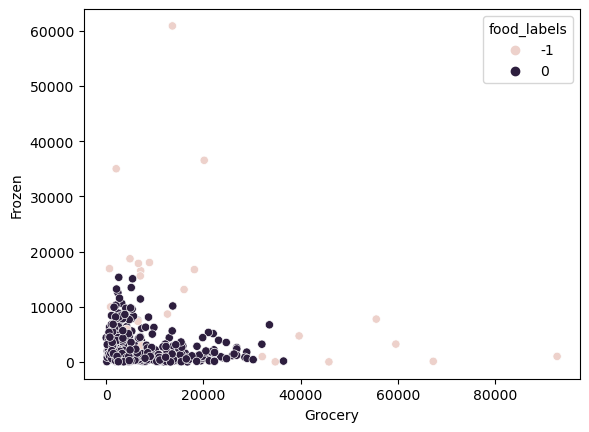

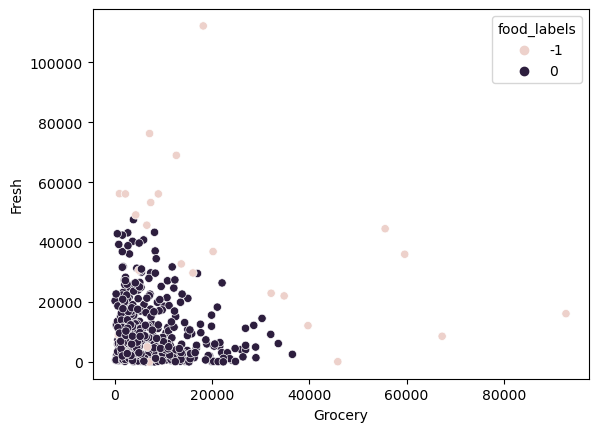

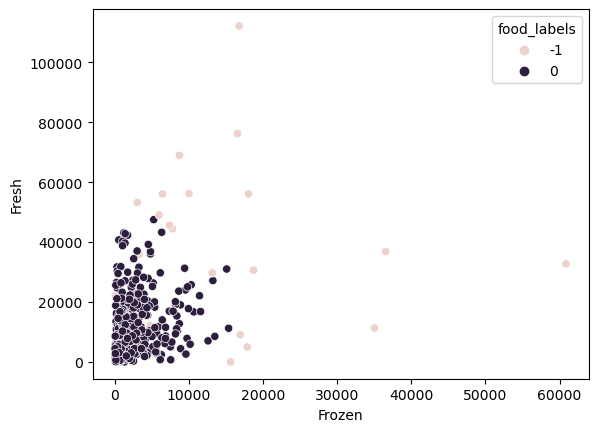

In [10]:
sns.scatterplot(x=df.Grocery, y=df.Frozen, hue=df.food_labels)
plt.show()

sns.scatterplot(x=df.Grocery, y=df.Fresh, hue=df.food_labels)
plt.show()

sns.scatterplot(x=df.Frozen, y=df.Fresh, hue=df.food_labels)
plt.show()

In [11]:
anomalies = df.loc[df['food_labels'] == -1]

In [12]:
anomalies.shape

(25, 12)

In [13]:
anomalies.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen,food_labels
125,1,3,76237,3473,7102,16538,778,918,0.679762,0.076517,0.271399,-1
258,1,1,56083,4563,2124,6422,730,3321,0.500054,0.022861,0.105138,-1
333,2,2,8565,4980,67298,131,38102,1215,0.076346,0.725341,0.001742,-1
277,1,3,9061,829,683,16919,621,139,0.080768,0.007329,0.277661,-1
181,1,3,112151,29627,18148,16745,4948,8550,1.000000,0.195576,0.274801,-1


In [14]:
anomalies['Region'].value_counts()

3    18
1     4
2     3
Name: Region, dtype: int64

In [15]:
if os.path.isfile('curriculum_logs.csv'):
    
    df = pd.read_csv('curriculum_logs.csv')
    
else:
    url = get_connection('curriculum_logs')
    
    query = '''
            SELECT *
            FROM logs
            '''
    
    df = pd.read_sql(query, url)

In [16]:
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [17]:
df.isna().sum()

date             0
time             0
path             1
user_id          0
cohort_id    52893
ip               0
dtype: int64

In [18]:
df.dtypes

date          object
time          object
path          object
user_id        int64
cohort_id    float64
ip            object
dtype: object

In [19]:
ip_df = df[["date", 'time']]
ip_df.head()

,date,time
0,2018-01-26,09:55:03
1,2018-01-26,09:56:02
2,2018-01-26,09:56:05
3,2018-01-26,09:56:06
4,2018-01-26,09:56:24


In [20]:
# dbsc = DBSCAN(eps = .10, min_samples = 20)

# # Fit the object
# dbsc.fit(ip_df)

In [21]:
df = pd.read_csv('winequality-red.csv')

In [22]:
df = pd.read_csv('winequality-white.csv')

In [23]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [24]:
wine_df = df[["fixed acidity", 'pH', 'alcohol']]
wine_df.head()

,fixed acidity,pH,alcohol
0,7.0,3.00,8.8
1,6.3,3.30,9.5
2,8.1,3.26,10.1
3,7.2,3.19,9.9
4,7.2,3.19,9.9


In [25]:
# Make the scaler
mms = MinMaxScaler()

#Fit/transform the scaler
wine_df = mms.fit_transform(wine_df)

wine_df

array([[0.30769231, 0.25454545, 0.12903226],
       [0.24038462, 0.52727273, 0.24193548],
       [0.41346154, 0.49090909, 0.33870968],
       ...,
       [0.25961538, 0.24545455, 0.22580645],
       [0.16346154, 0.56363636, 0.77419355],
       [0.21153846, 0.49090909, 0.61290323]])

In [26]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["fixed acidity", "pH", "alcohol" ]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(wine_df, columns=scaled_columns)

In [27]:
scaled_df.head()

,Scaled_fixed acidity,Scaled_pH,Scaled_alcohol
0,0.307692,0.254545,0.129032
1,0.240385,0.527273,0.241935
2,0.413462,0.490909,0.338710
3,0.326923,0.427273,0.306452
4,0.326923,0.427273,0.306452


In [28]:
df.reset_index().drop(columns='index', inplace = True)

In [29]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [30]:
 # Merge the scaled and non-scaled values into one dataframe
df = pd.merge(df, scaled_df, left_index=True, right_index=True)

In [31]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Scaled_fixed acidity,Scaled_pH,Scaled_alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0.307692,0.254545,0.129032
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0.240385,0.527273,0.241935
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0.413462,0.490909,0.338710
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0.326923,0.427273,0.306452
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0.326923,0.427273,0.306452


In [32]:
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(wine_df)

DBSCAN(eps=0.1, min_samples=20)

In [33]:
df['wine_labels'] = dbsc.labels_

In [34]:
df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Scaled_fixed acidity,Scaled_pH,Scaled_alcohol,wine_labels
835,7.5,0.42,0.34,4.30,0.040,34.0,108.0,0.99155,3.14,0.45,12.8,8,0.355769,0.381818,0.774194,0
3552,5.7,0.22,0.22,16.65,0.044,39.0,110.0,0.99855,3.24,0.48,9.0,6,0.182692,0.472727,0.161290,0
1710,8.1,0.31,0.24,1.60,0.032,10.0,67.0,0.99240,3.08,0.47,10.5,5,0.413462,0.327273,0.403226,0
2960,7.7,0.11,0.34,14.05,0.040,41.0,114.0,0.99634,3.07,0.59,11.0,7,0.375000,0.318182,0.483871,0
1635,7.5,0.14,0.74,1.60,0.035,21.0,126.0,0.99330,3.26,0.45,10.2,6,0.355769,0.490909,0.354839,0


In [35]:
df.wine_labels.value_counts()

 0    4859
-1      39
Name: wine_labels, dtype: int64

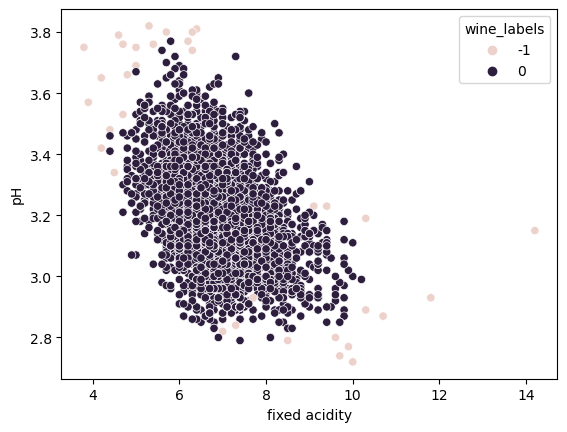

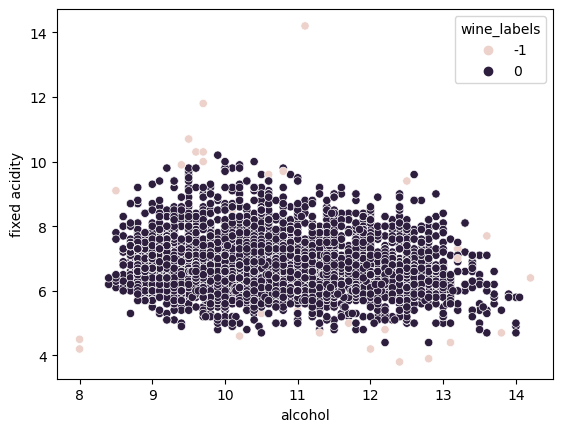

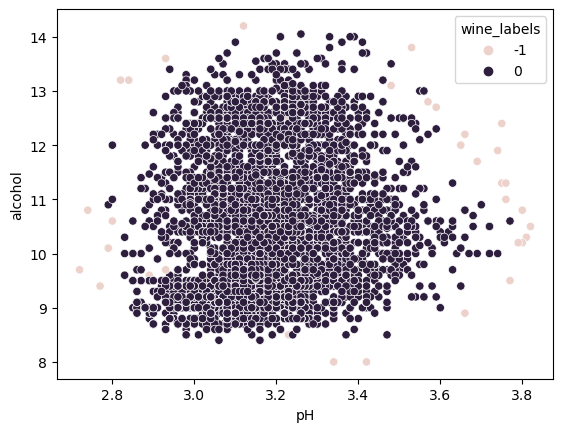

In [36]:
sns.scatterplot(x=df['fixed acidity'], y=df.pH, hue=df.wine_labels)
plt.show()

sns.scatterplot(x=df.alcohol, y=df['fixed acidity'], hue=df.wine_labels)
plt.show()

sns.scatterplot(x=df.pH, y=df.alcohol, hue=df.wine_labels)
plt.show()

In [37]:
anomalies = df.loc[df['wine_labels'] == -1]

In [38]:
anomalies.shape

(39, 16)

In [41]:
anomalies.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Scaled_fixed acidity,Scaled_pH,Scaled_alcohol,wine_labels
3514,7.7,0.38,0.23,10.8,0.030,28.0,95.0,0.99164,2.93,0.41,13.6,6,0.375000,0.190909,0.903226,-1
1960,8.5,0.17,0.31,1.0,0.024,13.0,91.0,0.99300,2.79,0.37,10.1,5,0.451923,0.063636,0.338710,-1
1214,9.7,0.24,0.45,1.2,0.033,11.0,59.0,0.99260,2.74,0.47,10.8,6,0.567308,0.018182,0.451613,-1
1014,6.1,0.16,0.27,12.6,0.064,63.0,162.0,0.99940,3.66,0.43,8.9,5,0.221154,0.854545,0.145161,-1
1900,10.0,0.23,0.27,14.1,0.033,45.0,166.0,0.99880,2.72,0.43,9.7,6,0.596154,0.000000,0.274194,-1
